# Qilin Zhou 2/10/2024

# Question 1 Train a deep MLP on MNIST

## Step 1: Load the dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()


The training set contains 60,000 grayscale images, each 28x28 pixels

In [ ]:
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

Each pixel intensity is represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

dtype('uint8')

## Step 2: Split the dataset to training, validation sets

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

## Step 3: Create the model using the Sequential API

In [ ]:
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

## Step 4: Compiling the model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

## Step 5: Training and Evaluating the model

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6077 - accuracy: 0.8447 - val_loss: 0.3012 - val_accuracy: 0.9172
Epoch 2/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2864 - accuracy: 0.9192 - val_loss: 0.2395 - val_accuracy: 0.9344
Epoch 3/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2347 - accuracy: 0.9329 - val_loss: 0.2004 - val_accuracy: 0.9426
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2002 - accuracy: 0.9430 - val_loss: 0.1787 - val_accuracy: 0.9516
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.1749 - accuracy: 0.9503 - val_loss: 0.1600 - val_accuracy: 0.9544
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1550 - accuracy: 0.9559 - val_loss: 0.1464 - val_accuracy: 0.9598
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1389 - accuracy: 0.9606 - val_loss: 0.1346 - val_accuracy:

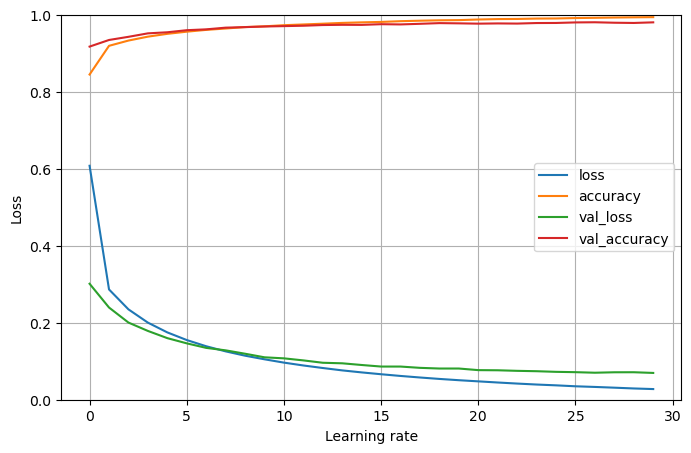

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0682 - accuracy: 0.9786


[0.06821319460868835, 0.978600025177002]

The current accuracy on the test set is under 98%. We see that the validation loss has not yet converged, since it continues to decrease. The learning rate could be adjusted to be larger.

## Step 6: Fine-tuning hyperparameters

* Randomized Grid Search

In [ ]:
from scipy.stats import randint

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def build_model(learning_rate=0.01, neurons_1=300, neurons_2=100, activation='relu'):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(neurons_1, activation=activation),
        keras.layers.Dense(neurons_2, activation=activation),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from scikeras.wrappers import KerasClassifier

keras_classifier = KerasClassifier(build_fn=build_model)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'model__learning_rate':[0.1, 0.3],
    'model__neurons_1': randint(50, 500),
    'model__neurons_2': randint(50, 500),
    'epochs':[30,100]
}

In [ ]:
# Initially tried a lot of randomized hyperparameters, but did not get over 98% accuracy.
# Interrupted due to execution time issues.
# But find learning_rate of 0.1 can reach accuracy over 98%
rnd_search = RandomizedSearchCV(keras_classifier, param_dist, n_iter=4, cv=3)
rnd_search.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

* Select the best model

In [ ]:
best_params = rnd_search.best_params_
best_params

## Step 7: Use the best model on the validation set and implement early stopping

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import os

root_logdir = os.path.join(os.curdir, "my_logs")

In [ ]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [ ]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",
                                                save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                  restore_best_weights=True)

best_model = build_model(learning_rate=0.1)
new_history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0185 - accuracy: 0.9948 - val_loss: 0.1024 - val_accuracy: 0.9744
Epoch 2/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.1363 - val_accuracy: 0.9642
Epoch 3/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.0884 - val_accuracy: 0.9790
Epoch 4/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.0799 - val_accuracy: 0.9808
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0077 - accuracy: 0.9975 - val_loss: 0.0772 - val_accuracy: 0.9822
Epoch 6/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0803 - val_accuracy: 0.9834
Epoch 7/100
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0766 - val_ac

## Step 8: Plot learning curves using TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006 --host=0.0.0.0

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 84344), started 3:38:37 ago. (Use '!kill 84344' to kill it.)

## Step 9: Plot the network architecture

In [ ]:
best_model = keras.models.load_model("my_keras_model.h5")
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 300)               235500    
                                                                 
 dense_22 (Dense)            (None, 100)               30100     
                                                                 
 dense_23 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


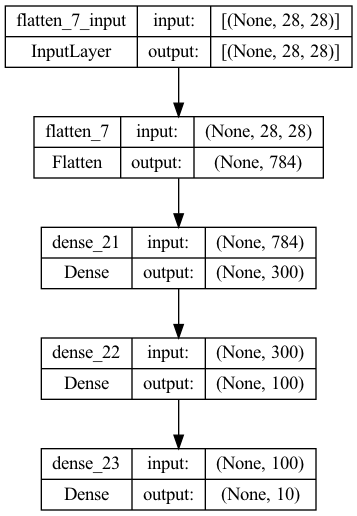

In [ ]:
keras.utils.plot_model(best_model, to_file='best_model_plot.png', show_shapes=True, show_layer_names=True)

## Step 10: Evaluate Current Model

In [ ]:
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0727 - accuracy: 0.9829


[0.07274184376001358, 0.9829000234603882]